In [1]:
import os

import numpy as np 
import nibabel as nib
import tensorflow as tf

from preprocess.get_subvolume import get_training_sub_volumes
from unet3d import *

np.set_printoptions(precision=2, suppress=True)

In [2]:
PARENT_DIR = os.getcwd()
img = os.path.join(PARENT_DIR, "A00028185\sub-A00028185_ses-NFB3_T1w.nii.gz")
img_mask = os.path.join(PARENT_DIR, "A00028185\sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz")
img = nib.load(img)
img_mask = nib.load(img_mask)
img.affine

array([[ -0.  ,  -0.  ,   1.  , -98.2 ],
       [ -1.  ,  -0.  ,  -0.  , 155.19],
       [  0.  ,  -1.  ,   0.  ,  99.04],
       [  0.  ,   0.  ,   0.  ,   1.  ]])

In [3]:
image = img.get_fdata()
image_mask = img_mask.get_fdata()
image[:,:,:].shape

(256, 256, 192)

In [4]:
SAVE_PATH = "train_sub_volumes"
PATH_SUBVOLUME = "images"
PATH_SUBMASK = "masks"
SAVE_PATH_SUBVOLUME = os.path.join(PARENT_DIR, SAVE_PATH, PATH_SUBVOLUME, "A00028185")
SAVE_PATH_SUBMASK = os.path.join(PARENT_DIR, SAVE_PATH, PATH_SUBMASK, "A00028185")

In [5]:
# get_training_sub_volumes(image, img.affine, image_mask, img_mask.affine, 
#                                 SAVE_PATH_SUBVOLUME, SAVE_PATH_SUBMASK, 
#                                 classes=1, 
#                                 orig_x = 256, orig_y = 256, orig_z = 192, 
#                                 output_x = 128, output_y = 128, output_z = 16,
#                                 stride_x = 40, stride_y = 40, stride_z = 8,
#                                 background_threshold=0.0)

In [6]:
feat_dir = 'train_sub_volumes'

train_ids = next(os.walk(feat_dir))[1] # [2]: files; [1]: directories
train_ids

['images', 'masks']

In [7]:
images=[]
images_mask=[]
for subvol in sorted(os.listdir(os.path.join(feat_dir, train_ids[0]))):
    for item in os.listdir(os.path.join(feat_dir, train_ids[0],subvol)):
        images.append(os.path.join(feat_dir,train_ids[0],subvol,item))

for subvol in sorted(os.listdir(os.path.join(feat_dir, train_ids[1]))):
    for item in os.listdir(os.path.join(feat_dir, train_ids[1],subvol)):
        images_mask.append(os.path.join(feat_dir,train_ids[1],subvol,item))


In [8]:
len(images_mask)

143

In [9]:
def load_image(file, label):
    nifti = np.asarray(nib.load(file.numpy().decode('utf-8')).get_fdata()).astype(np.int16)
    label = np.asarray(nib.load(label.numpy().decode('utf-8')).get_fdata()).astype(np.int16)
    return nifti, label


@tf.autograph.experimental.do_not_convert
def load_image_wrapper(file, label):
    image, label = tf.py_function(load_image, [file, label], [tf.int16, tf.int16])
    image.set_shape(tf.TensorShape([128, 128, 16]))
    label.set_shape(tf.TensorShape([128, 128, 16]))
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((images, images_mask))
dataset = dataset.map(load_image_wrapper, num_parallel_calls=32)
dataset = dataset.batch(32, drop_remainder=True)

In [10]:
model_unet=unet_3D(128, 128, 16)#(60,160,16)
model_unet.compile(optimizer='adam', loss = 'binary_crossentropy', #"categorical_crossentropy", 
                    metrics = ['accuracy', dice_coeff]) 

(None, 128, 128, 16, 1) 

(None, 128, 128, 16, 16)
(None, 128, 128, 16, 16)
(None, 64, 64, 8, 16)
(None, 64, 64, 8, 32)
(None, 64, 64, 8, 32)
(None, 32, 32, 4, 32)
(None, 32, 32, 4, 64)
(None, 32, 32, 4, 64)
(None, 16, 16, 2, 64)
(None, 16, 16, 2, 128)
(None, 16, 16, 2, 128)
(None, 8, 8, 1, 128) 

(None, 8, 8, 1, 256)
(None, 8, 8, 1, 256) 

(None, 16, 16, 2, 128)
(None, 16, 16, 2, 256)
(None, 16, 16, 2, 128)
(None, 16, 16, 2, 128)
(None, 32, 32, 4, 64)
(None, 32, 32, 4, 128)
(None, 32, 32, 4, 64)
(None, 32, 32, 4, 64)
(None, 64, 64, 8, 32)
(None, 64, 64, 8, 64)
(None, 64, 64, 8, 32)
(None, 64, 64, 8, 32)
(None, 128, 128, 16, 16)
(None, 128, 128, 16, 32)
(None, 128, 128, 16, 16)
(None, 128, 128, 16, 16) 

(None, 128, 128, 16, 1)


In [11]:
callbacks = ModelCheckpoint(PARENT_DIR, 
                            monitor='val_dice_coeff', #accuracy', # val_acc
                            verbose=1, 
                            mode='max',
                            save_best_only=True)

In [12]:
history = model_unet.fit(dataset,
                         epochs=100,
                         callbacks=[callbacks]) #Guardar la mejor epoca para validación

Epoch 1/100
4/4 [==============================] - 449s 110s/step - loss: 1.7813 - accuracy: 0.6824 - dice_coeff: 0.2994
Epoch 2/100
4/4 [==============================] - 435s 109s/step - loss: 0.7021 - accuracy: 0.7815 - dice_coeff: 0.4009
Epoch 3/100
4/4 [==============================] - 463s 116s/step - loss: 0.8100 - accuracy: 0.8215 - dice_coeff: 0.3700
Epoch 4/100
4/4 [==============================] - 453s 112s/step - loss: 0.5748 - accuracy: 0.7783 - dice_coeff: 0.4963
Epoch 5/100
4/4 [==============================] - 450s 111s/step - loss: 0.4929 - accuracy: 0.7917 - dice_coeff: 0.3135
Epoch 6/100
4/4 [==============================] - 442s 111s/step - loss: 0.4355 - accuracy: 0.7958 - dice_coeff: 0.2826
Epoch 7/100
4/4 [==============================] - 454s 114s/step - loss: 0.4718 - accuracy: 0.7654 - dice_coeff: 0.3480
Epoch 8/100
4/4 [==============================] - 463s 115s/step - loss: 0.4825 - accuracy: 0.7604 - dice_coeff: 0.3336
Epoch 9/100
4/4 [===============

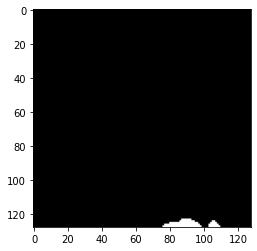

In [153]:
import matplotlib.pyplot as plt
plt.imshow(images_mask[1][:,:,15], cmap="gray")

In [ ]:
plot_slice(prueba_img, test_mask_img, predictions_img)